In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyvi
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.4 MB/s eta 0:00:00


In [3]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Concatenate
from keras.layers import LSTM, Embedding, Bidirectional, GRU
from keras.layers import SpatialDropout1D, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.initializers import Constant
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.losses import BinaryCrossentropy, CategoricalCrossentropy
import pickle
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import collections
from sklearn.utils.class_weight import compute_class_weight
from gensim import models
import torch
from transformers import AutoModel, AutoTokenizer
from pyvi.ViTokenizer import tokenize
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

In [4]:
data_train = pd.read_csv('/content/drive/My Drive/Thesis/data/data_train.csv')
data_val = pd.read_csv('/content/drive/My Drive/Thesis/data/data_val.csv')
data_test = pd.read_csv('/content/drive/My Drive/Thesis/data/data_test.csv')

data_train.drop('Unnamed: 0', axis = 1, inplace = True)
data_val.drop('Unnamed: 0', axis = 1, inplace = True)
data_test.drop('Unnamed: 0', axis = 1, inplace = True)

In [5]:
replace_dict = {0:1, 1:2,2:3}
data_train = data_train.replace(replace_dict).fillna(0)
data_val= data_val.replace(replace_dict).fillna(0)
data_test = data_test.replace(replace_dict).fillna(0)

In [6]:
data_train

,Content,quality,smell,shipping,packing,price,others,processed_content
0,chất lượng 10 điểm luôn á không mua shop nào m...,3.0,0.0,0.0,0.0,0.0,0.0,chất_lượng 10 điểm luôn á không mua shop nào m...
1,đóng gói cẩn thận giao hàng nhanh chóng dưỡng ...,3.0,0.0,3.0,3.0,0.0,0.0,đóng_gói cẩn_thận giao hàng nhanh_chóng dưỡng ...
2,dùng khá ổn da k bị căng chai nhỏ thôi nha nng,3.0,0.0,0.0,0.0,0.0,0.0,dùng khá ổn da k bị căng chai nhỏ thôi nha nng
3,bị kích ứng nỗi mụn nhiều hơn trước khi sử dụng,1.0,0.0,0.0,0.0,0.0,0.0,bị kích_ứng nỗi mụn nhiều hơn trước khi sử_dụng
4,đặt lần đầu 20 ngày vẫn ko thấy hàng hủy đặt l...,0.0,0.0,3.0,0.0,0.0,0.0,đặt lần đầu 20 ngày vẫn ko thấy hàng huỷ đặt l...
...,...,...,...,...,...,...,...,...
10570,Hầu như ai cũng biết đến em sữa rửa mặt thần t...,2.0,0.0,0.0,0.0,3.0,3.0,hầu_như ai cũng biết đến em sữa rửa mặt thần_t...
10571,da mình trộm vía xài hợp srm này tuy nhẹ nhưng...,3.0,0.0,3.0,0.0,3.0,0.0,da mình trộm_vía xài hợp srm này tuy nhẹ nhưng...
10572,"Sp tốt Tiki giao hàng rất nhanh, shipper cũng ...",3.0,0.0,3.0,0.0,0.0,3.0,sp tốt tiki giao hàng rất nhanh shipper cũng t...
10573,Da mình hay bị mụn ở vùng chữ T (da hỗn hợp th...,3.0,0.0,0.0,0.0,0.0,0.0,da mình hay bị mụn ở vùng chữ t da hỗn_hợp thi...


In [7]:
def make_outputs(df):
    outputs = []
    for row in range(len(df)):
        row_one_hot = []
        for col in range(1, len(df.columns)-1):
            sentiment = df.iloc[row, col]
            if   sentiment == 0: one_hot = [1, 0, 0, 0] # None
            elif sentiment == 1: one_hot = [0, 1, 0, 0] # Pos
            elif sentiment == 2: one_hot = [0, 0, 1, 0] # Neg
            elif sentiment == 3: one_hot = [0, 0, 0, 1] # Neu
            row_one_hot.append(one_hot)
        outputs.append(row_one_hot)
    return np.array(outputs, dtype='uint8')

In [8]:
label_train = make_outputs(data_train)
label_val = make_outputs(data_val)
label_test = make_outputs(data_test)

print('Train outputs:', label_train.shape)
print('Validate outputs:', label_val.shape)
print('Test outputs:', label_test.shape)

Train outputs: (10575, 6, 4)
Validate outputs: (2266, 6, 4)
Test outputs: (2267, 6, 4)


In [10]:
embeddings = {}
for state in ['train','val','test']:
  embeddings[state] = np.load(f'/content/drive/MyDrive/Thesis/embeddings_{state}.npy')

In [ ]:
print('Train inputs:', embeddings['train'].shape)
print('Validate inputs:', embeddings['val'].shape)
print('Test intputs:', embeddings['test'].shape)

Train inputs: (10575, 768)
Validate inputs: (2266, 768)
Test intputs: (2267, 768)


In [11]:
list_aspect = data_train.columns[1:-1]

# BiLSTM

In [100]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def bilstm_aspect(embedding_dim, num_aspects, output_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    # Define input layer
    input_layer = Input(shape=(embedding_dim,))

    # Expand dimensions to match the input shape requirement of the LSTM
    input_expanded = RepeatVector(num_aspects)(input_layer)

    # Define Bidirectional LSTM layer
    lstm_layer = Bidirectional(LSTM(units=200, activation='tanh', return_sequences=True))(input_expanded)

    # TimeDistributed layers to apply Dense layers across all time steps
    aspect_dense2 = TimeDistributed(Dense(128, activation='relu'))(lstm_layer)
    aspect_dropout1 = TimeDistributed(Dropout(0.2))(aspect_dense2)
    aspect_dense3 = TimeDistributed(Dense(64, activation='relu'))(aspect_dropout1)
    aspect_dense4 = TimeDistributed(Dense(output_dim, activation='softmax'))(aspect_dense3)  # Adjusted to output_dim

    # Define and compile the model
    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense4)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define callback for early stopping
    callback = EarlyStopping(monitor='val_loss', patience=3)

    # Train the model
    history = aspect_model.fit(
        x=padded_aspect_train,
        y=label_aspect_train,
        validation_data=(padded_aspect_val, label_aspect_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks if callbacks else [callback],
        verbose=verbose
    )

    return aspect_model, history

# Example usage
embedding_dim = 768
num_aspects = 6
output_dim = 4  # Ensure this matches the number of categories/classes you have

# Example placeholders for embeddings and labels
padded_aspect_train = embeddings['train']
padded_aspect_val = embeddings['val']
label_aspect_train = label_train  # Ensure shape (None, 6, 4)
label_aspect_val = label_val      # Ensure shape (None, 6, 4)

callback = EarlyStopping(monitor='val_loss', patience=5)
model_lstm, history_lstm = bilstm_aspect(embedding_dim, num_aspects, output_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=200, batch_size=128, callbacks=[callback], verbose=1)


Epoch 1/200
83/83 [==============================] - 7s 19ms/step - loss: 0.8750 - accuracy: 0.6731 - val_loss: 0.6777 - val_accuracy: 0.7310
Epoch 2/200
83/83 [==============================] - 1s 8ms/step - loss: 0.6410 - accuracy: 0.7480 - val_loss: 0.5703 - val_accuracy: 0.7749
Epoch 3/200
83/83 [==============================] - 1s 8ms/step - loss: 0.5437 - accuracy: 0.7934 - val_loss: 0.4874 - val_accuracy: 0.8222
Epoch 4/200
83/83 [==============================] - 1s 8ms/step - loss: 0.4825 - accuracy: 0.8256 - val_loss: 0.4400 - val_accuracy: 0.8452
Epoch 5/200
83/83 [==============================] - 1s 8ms/step - loss: 0.4431 - accuracy: 0.8414 - val_loss: 0.4082 - val_accuracy: 0.8534
Epoch 6/200
83/83 [==============================] - 1s 8ms/step - loss: 0.4134 - accuracy: 0.8515 - val_loss: 0.3831 - val_accuracy: 0.8625
Epoch 7/200
83/83 [==============================] - 1s 8ms/step - loss: 0.3885 - accuracy: 0.8609 - val_loss: 0.3627 - val_accuracy: 0.8679
Epoch 8/200


In [65]:
model_lstm.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 768)]             0         
                                                                 
 repeat_vector_10 (RepeatVe  (None, 6, 768)            0         
 ctor)                                                           
                                                                 
 bidirectional_13 (Bidirect  (None, 6, 400)            1550400   
 ional)                                                          
                                                                 
 conv1d_7 (Conv1D)           (None, 6, 64)             76864     
                                                                 
 time_distributed_58 (TimeD  (None, 6, 128)            8320      
 istributed)                                                     
                                                           

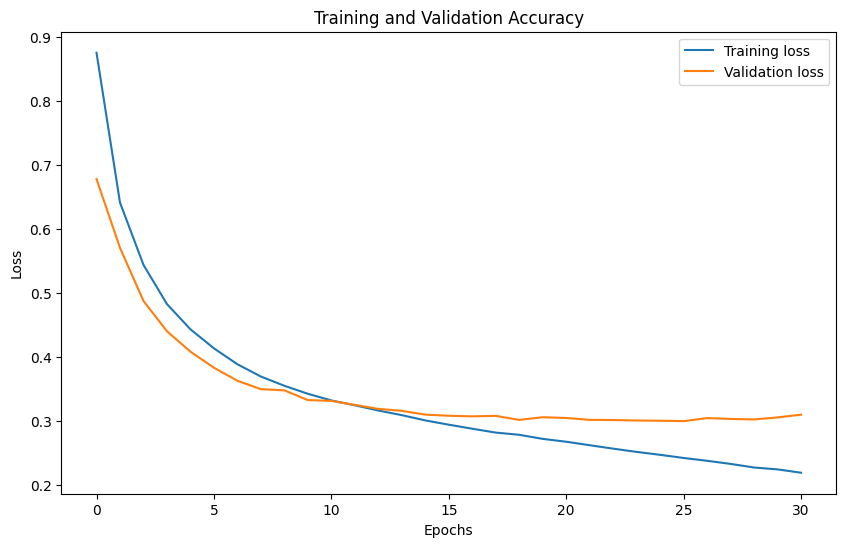

In [102]:
plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['loss'], label='Training loss')
plt.plot(history_lstm.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [103]:
def predict(model, inputs, batch_size=1, verbose=0):
    y_pred = model.predict(inputs, batch_size=batch_size, verbose=verbose)
    y_pred = y_pred.reshape(len(y_pred), -1, 4)
    return np.argmax(y_pred, axis=-1)
def print_acsa_pred(replacements, categories, sentence_pred):
    sentiments = map(lambda x: replacements[x], sentence_pred)
    for category, sentiment in zip(categories, sentiments):
        if sentiment: print(f'=> {category}: {sentiment}')

### Result

In [107]:
predictions = model_lstm.predict(embeddings['test'])

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = np.argmax(label_test, axis=-1)

# Evaluate the model and store the results in a DataFrame
output_lstm = pd.DataFrame()
for i in range(num_aspects):
    aspect_name = data_train.columns[i+1]
    print(f"{aspect_name}:")
    report = classification_report(true_labels[:, i], predicted_labels[:, i], target_names=['None', 'Negative', 'Neutral', 'Positive'], output_dict=True)

    # Create a DataFrame from the report
    aspect_report_df = pd.DataFrame(report).transpose()
    aspect_report_df['Aspect'] = aspect_name  # Add a column for the aspect name

    # Append the report for this aspect to the main DataFrame
    output_lstm = pd.concat([output_lstm, aspect_report_df], ignore_index=False)

    # If you want to print the classification report as well
    print(aspect_report_df)


71/71 [==============================] - 0s 5ms/step
quality:
              precision    recall  f1-score      support   Aspect
None           0.805601  0.670782  0.732036   729.000000  quality
Negative       0.538462  0.466667  0.500000    75.000000  quality
Neutral        0.414474  0.315000  0.357955   200.000000  quality
Positive       0.792100  0.904988  0.844789  1263.000000  quality
accuracy       0.763123  0.763123  0.763123     0.763123  quality
macro avg      0.637659  0.589359  0.608695  2267.000000  quality
weighted avg   0.754735  0.763123  0.754175  2267.000000  quality
smell:
              precision    recall  f1-score      support Aspect
None           0.975434  0.985401  0.980392  2055.000000  smell
Negative       0.487805  0.487805  0.487805    41.000000  smell
Neutral        0.000000  0.000000  0.000000    17.000000  smell
Positive       0.724832  0.701299  0.712871   154.000000  smell
accuracy       0.949713  0.949713  0.949713     0.949713  smell
macro avg      0.54

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [110]:
output_lstm.to_csv('/content/drive/MyDrive/Thesis/ABSA/output/Multi Task/sentiment_bilstm.csv')

In [68]:
y_pred_lstm = predict(model_lstm, embeddings['test'], verbose=1)
model_lstm.evaluate(embeddings['test'], verbose=1)

71/71 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [69]:
replacements = {0: None, 1: 'positive', 2: 'negative', 3: 'neutral'}
categories = data_test.columns[1:]
print('Example:', data_test['Content'][6])
print_acsa_pred(replacements,categories, y_pred_lstm[6])

Example: dùng ổn nhưng sẽ hơi khô nên không hợp với da khô hoặc hỗn hợp thiên khoi
=> quality: negative


In [70]:
y_test_argmax = np.argmax(label_test, axis=-1)
y_test_argmax

array([[3, 0, 3, 0, 0, 0],
       [2, 3, 0, 0, 2, 0],
       [0, 0, 0, 3, 0, 3],
       ...,
       [0, 0, 3, 0, 0, 0],
       [0, 0, 0, 3, 0, 0],
       [0, 0, 3, 3, 0, 0]])

In [71]:
aspect_test = []
aspect_pred = []

for row_test, row_pred in zip(y_test_argmax, y_test_argmax):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_test.append(bool(col_test) * categories[index])
        aspect_pred.append(bool(col_pred) * categories[index])

In [114]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)

# Convert the dictionary to a pandas DataFrame
aspect_report_df = pd.DataFrame(aspect_report).transpose()
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))

              precision    recall  f1-score   support

                 0.9242    0.9581    0.9408      9443
      others     0.7661    0.4411    0.5598       594
     packing     0.9258    0.9529    0.9392       786
       price     0.7687    0.7744    0.7715       266
     quality     0.9072    0.8706    0.8885      1538
    shipping     0.9544    0.9332    0.9437       763
       smell     0.8663    0.7028    0.7760       212

    accuracy                         0.9163     13602
   macro avg     0.8732    0.8047    0.8314     13602
weighted avg     0.9132    0.9163    0.9125     13602



In [116]:
aspect_report_df.to_csv('/content/drive/MyDrive/Thesis/ABSA/output/Multi Task/aspect_bilstm.csv')

# BiLSTM + Conv

In [120]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, TimeDistributed, RepeatVector, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def bilstm_conv(embedding_dim, num_aspects, output_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    # Define input layer
    input_layer = Input(shape=(embedding_dim,))

    # Expand dimensions to match the input shape requirement of the LSTM
    input_expanded = RepeatVector(num_aspects)(input_layer)

    # Define Bidirectional LSTM layer
    lstm_layer = Bidirectional(LSTM(units=200, activation='tanh', return_sequences=True))(input_expanded)

    # Adding a Conv1D layer after LSTM
    conv_layer = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(lstm_layer)

    # TimeDistributed layer to apply Dense layers across all time steps
    aspect_dense2 = TimeDistributed(Dense(128, activation='relu'))(conv_layer)
    aspect_dropout1 = TimeDistributed(Dropout(0.2))(aspect_dense2)
    aspect_dense3 = TimeDistributed(Dense(64, activation='relu'))(aspect_dropout1)
    aspect_dense4 = TimeDistributed(Dense(32, activation='relu'))(aspect_dense3)

    # Output layer: num_aspects * output_dim units corresponding to 6 aspects with 4 categories each
    aspect_dense5 = TimeDistributed(Dense(units=4, activation='softmax'))(aspect_dense4)

    # Define and compile the model
    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense5)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define callback for early stopping
    callback = EarlyStopping(monitor='val_loss', patience=3)

    # Train the model
    history = aspect_model.fit(
        x=padded_aspect_train,
        y=label_aspect_train,
        validation_data=(padded_aspect_val, label_aspect_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks if callbacks else [callback],
        verbose=verbose
    )

    return aspect_model, history

# Example usage
embedding_dim = 768
num_aspects = 6
output_dim = 4

# Example placeholders for embeddings and labels
padded_aspect_train = embeddings['train']
padded_aspect_val = embeddings['val']
label_aspect_train = label_train
label_aspect_val = label_val

callback = EarlyStopping(monitor='val_loss', patience=5)
model_lstm_conv, history_lstm_conv = bilstm_conv(embedding_dim, num_aspects, output_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=200, batch_size=128, callbacks=[callback], verbose=1)


Epoch 1/200
83/83 [==============================] - 7s 19ms/step - loss: 0.8502 - accuracy: 0.6945 - val_loss: 0.6613 - val_accuracy: 0.7586
Epoch 2/200
83/83 [==============================] - 1s 8ms/step - loss: 0.5980 - accuracy: 0.7755 - val_loss: 0.5113 - val_accuracy: 0.8208
Epoch 3/200
83/83 [==============================] - 1s 8ms/step - loss: 0.4829 - accuracy: 0.8242 - val_loss: 0.4221 - val_accuracy: 0.8485
Epoch 4/200
83/83 [==============================] - 1s 9ms/step - loss: 0.4153 - accuracy: 0.8493 - val_loss: 0.3765 - val_accuracy: 0.8611
Epoch 5/200
83/83 [==============================] - 1s 8ms/step - loss: 0.3753 - accuracy: 0.8639 - val_loss: 0.3550 - val_accuracy: 0.8719
Epoch 6/200
83/83 [==============================] - 1s 8ms/step - loss: 0.3511 - accuracy: 0.8738 - val_loss: 0.3362 - val_accuracy: 0.8790
Epoch 7/200
83/83 [==============================] - 1s 9ms/step - loss: 0.3316 - accuracy: 0.8824 - val_loss: 0.3288 - val_accuracy: 0.8826
Epoch 8/200


In [126]:
predictions = model_lstm_conv.predict(embeddings['test'])

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = np.argmax(label_test, axis=-1)

# Evaluate the model and store the results in a DataFrame
output_lstm_conv = pd.DataFrame()
for i in range(num_aspects):
    aspect_name = data_train.columns[i+1]
    print(f"{aspect_name}:")
    report = classification_report(true_labels[:, i], predicted_labels[:, i], target_names=['None', 'Negative', 'Neutral', 'Positive'], output_dict=True)

    # Create a DataFrame from the report
    aspect_report_df = pd.DataFrame(report).transpose()
    aspect_report_df['Aspect'] = aspect_name  # Add a column for the aspect name

    # Append the report for this aspect to the main DataFrame
    output_lstm_conv = pd.concat([output_lstm_conv, aspect_report_df], ignore_index=False)

    # If you want to print the classification report as well
    print(aspect_report_df)
    output_lstm_conv.to_csv('/content/drive/MyDrive/Thesis/ABSA/output/Multi Task/sentiment_bilstm_conv.csv')

71/71 [==============================] - 0s 3ms/step
quality:
              precision    recall  f1-score      support   Aspect
None           0.768000  0.790123  0.778905   729.000000  quality
Negative       0.584615  0.506667  0.542857    75.000000  quality
Neutral        0.494505  0.225000  0.309278   200.000000  quality
Positive       0.818516  0.882027  0.849085  1263.000000  quality
accuracy       0.782091  0.782091  0.782091     0.782091  quality
macro avg      0.666409  0.600954  0.620031  2267.000000  quality
weighted avg   0.765948  0.782091  0.768763  2267.000000  quality
smell:
              precision    recall  f1-score     support Aspect
None           0.970841  0.988321  0.979503  2055.00000  smell
Negative       0.536585  0.536585  0.536585    41.00000  smell
Neutral        0.000000  0.000000  0.000000    17.00000  smell
Positive       0.723881  0.629870  0.673611   154.00000  smell
accuracy       0.948390  0.948390  0.948390     0.94839  smell
macro avg      0.557827  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [75]:
def predict(model, inputs, batch_size=1, verbose=0):
    y_pred = model.predict(inputs, batch_size=batch_size, verbose=verbose)
    y_pred = y_pred.reshape(len(y_pred), -1, 4)
    return np.argmax(y_pred, axis=-1)
def print_acsa_pred(replacements, categories, sentence_pred):
    sentiments = map(lambda x: replacements[x], sentence_pred)
    for category, sentiment in zip(categories, sentiments):
        if sentiment: print(f'=> {category}: {sentiment}')

In [122]:
y_pred_lstm_conv = predict(model_lstm, embeddings['test'], verbose=1)
model_lstm_conv.evaluate(embeddings['test'], verbose=1)

71/71 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [76]:
replacements = {0: None, 1: 'positive', 2: 'negative', 3: 'neutral'}
categories = data_test.columns[1:]
print('Example:', data_test['Content'][6])
print_acsa_pred(replacements,categories, y_pred_lstm_conv[6])

Example: dùng ổn nhưng sẽ hơi khô nên không hợp với da khô hoặc hỗn hợp thiên khoi
=> quality: negative


In [77]:
y_test_argmax = np.argmax(label_test, axis=-1)
y_test_argmax

array([[3, 0, 3, 0, 0, 0],
       [2, 3, 0, 0, 2, 0],
       [0, 0, 0, 3, 0, 3],
       ...,
       [0, 0, 3, 0, 0, 0],
       [0, 0, 0, 3, 0, 0],
       [0, 0, 3, 3, 0, 0]])

In [123]:
aspect_test = []
aspect_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred_lstm_conv):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_test.append(bool(col_test) * categories[index])
        aspect_pred.append(bool(col_pred) * categories[index])


In [124]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)

# Convert the dictionary to a pandas DataFrame
aspect_report_df = pd.DataFrame(aspect_report).transpose()
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))
aspect_report_df.to_csv('/content/drive/MyDrive/Thesis/ABSA/output/Multi Task/aspect_bilstm_conv.csv')

              precision    recall  f1-score   support

                 0.9300    0.9478    0.9388      9443
      others     0.7500    0.4899    0.5927       594
     packing     0.9457    0.9313    0.9385       786
       price     0.8038    0.6316    0.7074       266
     quality     0.8554    0.9233    0.8881      1538
    shipping     0.9431    0.9345    0.9388       763
       smell     0.8429    0.7594    0.7990       212

    accuracy                         0.9142     13602
   macro avg     0.8673    0.8025    0.8290     13602
weighted avg     0.9115    0.9142    0.9112     13602



# BiGRU

In [125]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def bilstm_aspect(embedding_dim, num_aspects, output_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    # Define input layer
    input_layer = Input(shape=(embedding_dim,))

    # Expand dimensions to match the input shape requirement of the LSTM
    input_expanded = RepeatVector(num_aspects)(input_layer)

    # Define Bidirectional LSTM layer
    lstm_layer = Bidirectional(GRU(units=200, activation='tanh', return_sequences=True))(input_expanded)

    # TimeDistributed layers to apply Dense layers across all time steps
    aspect_dense2 = TimeDistributed(Dense(128, activation='relu'))(lstm_layer)
    aspect_dropout1 = TimeDistributed(Dropout(0.2))(aspect_dense2)
    aspect_dense3 = TimeDistributed(Dense(64, activation='relu'))(aspect_dropout1)
    aspect_dense4 = TimeDistributed(Dense(output_dim, activation='softmax'))(aspect_dense3)  # Adjusted to output_dim

    # Define and compile the model
    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense4)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define callback for early stopping
    callback = EarlyStopping(monitor='val_loss', patience=3)

    # Train the model
    history = aspect_model.fit(
        x=padded_aspect_train,
        y=label_aspect_train,
        validation_data=(padded_aspect_val, label_aspect_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks if callbacks else [callback],
        verbose=verbose
    )

    return aspect_model, history

# Example usage
embedding_dim = 768
num_aspects = 6
output_dim = 4  # Ensure this matches the number of categories/classes you have

# Example placeholders for embeddings and labels
padded_aspect_train = embeddings['train']
padded_aspect_val = embeddings['val']
label_aspect_train = label_train  # Ensure shape (None, 6, 4)
label_aspect_val = label_val      # Ensure shape (None, 6, 4)

callback = EarlyStopping(monitor='val_loss', patience=5)
model_GRU, history_GRU = bilstm_aspect(embedding_dim, num_aspects, output_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=200, batch_size=128, callbacks=[callback], verbose=1)


Epoch 1/200
83/83 [==============================] - 7s 34ms/step - loss: 0.8595 - accuracy: 0.6589 - val_loss: 0.6766 - val_accuracy: 0.7218
Epoch 2/200
83/83 [==============================] - 1s 15ms/step - loss: 0.6557 - accuracy: 0.7352 - val_loss: 0.6019 - val_accuracy: 0.7587
Epoch 3/200
83/83 [==============================] - 2s 21ms/step - loss: 0.5811 - accuracy: 0.7741 - val_loss: 0.5169 - val_accuracy: 0.8087
Epoch 4/200
83/83 [==============================] - 2s 23ms/step - loss: 0.5011 - accuracy: 0.8155 - val_loss: 0.4439 - val_accuracy: 0.8360
Epoch 5/200
83/83 [==============================] - 1s 17ms/step - loss: 0.4390 - accuracy: 0.8380 - val_loss: 0.3971 - val_accuracy: 0.8500
Epoch 6/200
83/83 [==============================] - 3s 33ms/step - loss: 0.4038 - accuracy: 0.8512 - val_loss: 0.3722 - val_accuracy: 0.8613
Epoch 7/200
83/83 [==============================] - 1s 18ms/step - loss: 0.3826 - accuracy: 0.8585 - val_loss: 0.3580 - val_accuracy: 0.8659
Epoch 

In [127]:
predictions = model_GRU.predict(embeddings['test'])

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = np.argmax(label_test, axis=-1)

# Evaluate the model and store the results in a DataFrame
output_GRU = pd.DataFrame()
for i in range(num_aspects):
    aspect_name = data_train.columns[i+1]
    print(f"{aspect_name}:")
    report = classification_report(true_labels[:, i], predicted_labels[:, i], target_names=['None', 'Negative', 'Neutral', 'Positive'], output_dict=True)

    # Create a DataFrame from the report
    aspect_report_df = pd.DataFrame(report).transpose()
    aspect_report_df['Aspect'] = aspect_name  # Add a column for the aspect name

    # Append the report for this aspect to the main DataFrame
    output_GRU = pd.concat([output_GRU, aspect_report_df], ignore_index=False)

    # If you want to print the classification report as well
    print(aspect_report_df)
    output_GRU.to_csv('/content/drive/MyDrive/Thesis/ABSA/output/Multi Task/sentiment_GRU.csv')

71/71 [==============================] - 1s 4ms/step
quality:
              precision    recall  f1-score      support   Aspect
None           0.743429  0.814815  0.777487   729.000000  quality
Negative       0.619048  0.520000  0.565217    75.000000  quality
Neutral        0.435065  0.335000  0.378531   200.000000  quality
Positive       0.844125  0.836105  0.840095  1263.000000  quality
accuracy       0.774592  0.774592  0.774592     0.774592  quality
macro avg      0.660417  0.626480  0.640333  2267.000000  quality
weighted avg   0.768210  0.774592  0.770148  2267.000000  quality
smell:
              precision    recall  f1-score      support Aspect
None           0.970897  0.990268  0.980487  2055.000000  smell
Negative       0.562500  0.658537  0.606742    41.000000  smell
Neutral        0.000000  0.000000  0.000000    17.000000  smell
Positive       0.804878  0.642857  0.714801   154.000000  smell
accuracy       0.953242  0.953242  0.953242     0.953242  smell
macro avg      0.58

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [129]:
y_pred_GRU = predict(model_GRU, embeddings['test'], verbose=1)
model_GRU.evaluate(embeddings['test'], verbose=1)

71/71 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [130]:
replacements = {0: None, 1: 'positive', 2: 'negative', 3: 'neutral'}
categories = data_test.columns[1:]
print('Example:', data_test['Content'][6])
print_acsa_pred(replacements,categories, y_pred_GRU[6])

Example: dùng ổn nhưng sẽ hơi khô nên không hợp với da khô hoặc hỗn hợp thiên khoi
=> quality: negative


In [131]:
y_test_argmax = np.argmax(label_test, axis=-1)
y_test_argmax

array([[3, 0, 3, 0, 0, 0],
       [2, 3, 0, 0, 2, 0],
       [0, 0, 0, 3, 0, 3],
       ...,
       [0, 0, 3, 0, 0, 0],
       [0, 0, 0, 3, 0, 0],
       [0, 0, 3, 3, 0, 0]])

In [132]:
aspect_test = []
aspect_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred_GRU):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_test.append(bool(col_test) * categories[index])
        aspect_pred.append(bool(col_pred) * categories[index])


In [133]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))

              precision    recall  f1-score   support

                 0.9217    0.9618    0.9413      9443
      others     0.7975    0.4310    0.5596       594
     packing     0.9383    0.9478    0.9430       786
       price     0.8043    0.6955    0.7460       266
     quality     0.9080    0.8667    0.8869      1538
    shipping     0.9385    0.9397    0.9391       763
       smell     0.8830    0.7123    0.7885       212

    accuracy                         0.9167     13602
   macro avg     0.8845    0.7935    0.8292     13602
weighted avg     0.9137    0.9167    0.9122     13602



In [134]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)

# Convert the dictionary to a pandas DataFrame
aspect_report_df = pd.DataFrame(aspect_report).transpose()
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))
aspect_report_df.to_csv('/content/drive/MyDrive/Thesis/ABSA/output/Multi Task/aspect_GRU.csv')

              precision    recall  f1-score   support

                 0.9217    0.9618    0.9413      9443
      others     0.7975    0.4310    0.5596       594
     packing     0.9383    0.9478    0.9430       786
       price     0.8043    0.6955    0.7460       266
     quality     0.9080    0.8667    0.8869      1538
    shipping     0.9385    0.9397    0.9391       763
       smell     0.8830    0.7123    0.7885       212

    accuracy                         0.9167     13602
   macro avg     0.8845    0.7935    0.8292     13602
weighted avg     0.9137    0.9167    0.9122     13602



# BiGRU + Conv

In [135]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, TimeDistributed, RepeatVector, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def bilstm_conv(embedding_dim, num_aspects, output_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    # Define input layer
    input_layer = Input(shape=(embedding_dim,))

    # Expand dimensions to match the input shape requirement of the LSTM
    input_expanded = RepeatVector(num_aspects)(input_layer)

    # Define Bidirectional LSTM layer
    lstm_layer = Bidirectional(GRU(units=200, activation='tanh', return_sequences=True))(input_expanded)

    # Adding a Conv1D layer after LSTM
    conv_layer = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(lstm_layer)

    # TimeDistributed layer to apply Dense layers across all time steps
    aspect_dense2 = TimeDistributed(Dense(128, activation='relu'))(conv_layer)
    aspect_dropout1 = TimeDistributed(Dropout(0.2))(aspect_dense2)
    aspect_dense3 = TimeDistributed(Dense(64, activation='relu'))(aspect_dropout1)
    aspect_dense4 = TimeDistributed(Dense(32, activation='relu'))(aspect_dense3)

    # Output layer: num_aspects * output_dim units corresponding to 6 aspects with 4 categories each
    aspect_dense5 = TimeDistributed(Dense(units=4, activation='softmax'))(aspect_dense4)

    # Define and compile the model
    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense5)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define callback for early stopping
    callback = EarlyStopping(monitor='val_loss', patience=3)

    # Train the model
    history = aspect_model.fit(
        x=padded_aspect_train,
        y=label_aspect_train,
        validation_data=(padded_aspect_val, label_aspect_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks if callbacks else [callback],
        verbose=verbose
    )

    return aspect_model, history

# Example usage
embedding_dim = 768
num_aspects = 6
output_dim = 4

# Example placeholders for embeddings and labels
padded_aspect_train = embeddings['train']
padded_aspect_val = embeddings['val']
label_aspect_train = label_train
label_aspect_val = label_val

callback = EarlyStopping(monitor='val_loss', patience=5)
model_gru_conv, history_gru_conv = bilstm_conv(embedding_dim, num_aspects, output_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=200, batch_size=128, callbacks=[callback], verbose=1)


Epoch 1/200
83/83 [==============================] - 5s 17ms/step - loss: 0.8230 - accuracy: 0.6901 - val_loss: 0.6562 - val_accuracy: 0.7513
Epoch 2/200
83/83 [==============================] - 1s 8ms/step - loss: 0.6206 - accuracy: 0.7602 - val_loss: 0.5494 - val_accuracy: 0.7905
Epoch 3/200
83/83 [==============================] - 1s 8ms/step - loss: 0.5223 - accuracy: 0.8058 - val_loss: 0.4517 - val_accuracy: 0.8361
Epoch 4/200
83/83 [==============================] - 1s 8ms/step - loss: 0.4438 - accuracy: 0.8385 - val_loss: 0.4054 - val_accuracy: 0.8472
Epoch 5/200
83/83 [==============================] - 1s 16ms/step - loss: 0.4021 - accuracy: 0.8502 - val_loss: 0.3685 - val_accuracy: 0.8623
Epoch 6/200
83/83 [==============================] - 1s 17ms/step - loss: 0.3722 - accuracy: 0.8634 - val_loss: 0.3507 - val_accuracy: 0.8727
Epoch 7/200
83/83 [==============================] - 1s 15ms/step - loss: 0.3511 - accuracy: 0.8732 - val_loss: 0.3352 - val_accuracy: 0.8779
Epoch 8/2

In [136]:
predictions = model_gru_conv.predict(embeddings['test'])

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = np.argmax(label_test, axis=-1)

# Evaluate the model and store the results in a DataFrame
output_GRU_conv = pd.DataFrame()
for i in range(num_aspects):
    aspect_name = data_train.columns[i+1]
    print(f"{aspect_name}:")
    report = classification_report(true_labels[:, i], predicted_labels[:, i], target_names=['None', 'Negative', 'Neutral', 'Positive'], output_dict=True)

    # Create a DataFrame from the report
    aspect_report_df = pd.DataFrame(report).transpose()
    aspect_report_df['Aspect'] = aspect_name  # Add a column for the aspect name

    # Append the report for this aspect to the main DataFrame
    output_GRU_conv = pd.concat([output_GRU_conv, aspect_report_df], ignore_index=False)

    # If you want to print the classification report as well
    print(aspect_report_df)
    output_GRU_conv.to_csv('/content/drive/MyDrive/Thesis/ABSA/output/Multi Task/sentiment_GRU_conv.csv')

71/71 [==============================] - 1s 6ms/step
quality:
              precision    recall  f1-score      support   Aspect
None           0.799120  0.747599  0.772502   729.000000  quality
Negative       0.583333  0.560000  0.571429    75.000000  quality
Neutral        0.419162  0.350000  0.381471   200.000000  quality
Positive       0.827637  0.882027  0.853967  1263.000000  quality
accuracy       0.781209  0.781209  0.781209     0.781209  quality
macro avg      0.657313  0.634907  0.644842  2267.000000  quality
weighted avg   0.774348  0.781209  0.776738  2267.000000  quality
smell:
              precision    recall  f1-score      support Aspect
None           0.975938  0.986861  0.981369  2055.000000  smell
Negative       0.476190  0.731707  0.576923    41.000000  smell
Neutral        0.000000  0.000000  0.000000    17.000000  smell
Positive       0.792000  0.642857  0.709677   154.000000  smell
accuracy       0.951478  0.951478  0.951478     0.951478  smell
macro avg      0.56

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [137]:
y_pred_gru_conv = predict(model_gru_conv, embeddings['test'], verbose=1)
model_gru_conv.evaluate(embeddings['test'], verbose=1)

71/71 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [147]:
aspect_test = []
aspect_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred_gru_conv):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_test.append(bool(col_test) * categories[index])
        aspect_pred.append(bool(col_pred) * categories[index])


In [148]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))

              precision    recall  f1-score   support

                 0.9339    0.9501    0.9419      9443
      others     0.7938    0.4731    0.5928       594
     packing     0.9154    0.9504    0.9326       786
       price     0.7356    0.8158    0.7736       266
     quality     0.8839    0.9109    0.8972      1538
    shipping     0.9471    0.9384    0.9427       763
       smell     0.8571    0.7642    0.8080       212

    accuracy                         0.9187     13602
   macro avg     0.8667    0.8290    0.8413     13602
weighted avg     0.9167    0.9187    0.9158     13602



In [149]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)

# Convert the dictionary to a pandas DataFrame
aspect_report_df = pd.DataFrame(aspect_report).transpose()
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))
aspect_report_df.to_csv('/content/drive/MyDrive/Thesis/ABSA/output/Multi Task/aspect_gru_conv.csv')

              precision    recall  f1-score   support

                 0.9339    0.9501    0.9419      9443
      others     0.7938    0.4731    0.5928       594
     packing     0.9154    0.9504    0.9326       786
       price     0.7356    0.8158    0.7736       266
     quality     0.8839    0.9109    0.8972      1538
    shipping     0.9471    0.9384    0.9427       763
       smell     0.8571    0.7642    0.8080       212

    accuracy                         0.9187     13602
   macro avg     0.8667    0.8290    0.8413     13602
weighted avg     0.9167    0.9187    0.9158     13602



# GRU + LSTM + Conv

In [141]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, TimeDistributed, RepeatVector, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def bilstm_conv(embedding_dim, num_aspects, output_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    # Define input layer
    input_layer = Input(shape=(embedding_dim,))

    # Expand dimensions to match the input shape requirement of the LSTM
    input_expanded = RepeatVector(num_aspects)(input_layer)

    # Define Bidirectional LSTM layer
    lstm_layer = Bidirectional(LSTM(units=200, activation='tanh', return_sequences=True))(input_expanded)
    conv_layer = Conv1D(128, kernel_size=1, padding="same", kernel_initializer="he_uniform")(lstm_layer)
    avg_pool1 = GlobalAveragePooling1D()(conv_layer)
    max_pool1 = GlobalMaxPooling1D()(conv_layer)

    gru_layer = Bidirectional(GRU(units=200, activation='tanh', return_sequences=True))(input_expanded)
    conv_layer = Conv1D(128, kernel_size=1, padding="valid", kernel_initializer="he_uniform")(gru_layer)
    avg_pool2 = GlobalAveragePooling1D()(conv_layer)
    max_pool2 = GlobalMaxPooling1D()(conv_layer)


    concat = Concatenate(axis=-1)([avg_pool1, max_pool1, avg_pool2, max_pool2])

    # TimeDistributed layer to apply Dense layers across all time steps
    aspect_dense2 = TimeDistributed(Dense(128, activation='relu'))(conv_layer)
    aspect_dropout1 = TimeDistributed(Dropout(0.2))(aspect_dense2)
    aspect_dense3 = TimeDistributed(Dense(64, activation='relu'))(aspect_dropout1)
    aspect_dense4 = TimeDistributed(Dense(32, activation='relu'))(aspect_dense3)

    # Output layer: num_aspects * output_dim units corresponding to 6 aspects with 4 categories each
    aspect_dense5 = TimeDistributed(Dense(units=4, activation='softmax'))(aspect_dense4)

    # Define and compile the model
    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense5)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define callback for early stopping
    callback = EarlyStopping(monitor='val_loss', patience=3)
    # Train the model
    history = aspect_model.fit(
        x=padded_aspect_train,
        y=label_aspect_train,
        validation_data=(padded_aspect_val, label_aspect_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks if callbacks else [callback],
        verbose=verbose
    )

    return aspect_model, history

# Example usage
embedding_dim = 768
num_aspects = 6
output_dim = 4

# Example placeholders for embeddings and labels
padded_aspect_train = embeddings['train']
padded_aspect_val = embeddings['val']
label_aspect_train = label_train
label_aspect_val = label_val

callback = EarlyStopping(monitor='val_loss', patience=5)
model_lstm_gru_conv, history_lstm_gru_conv = bilstm_conv(embedding_dim, num_aspects, output_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=200, batch_size=128, callbacks=[callback], verbose=1)


Epoch 1/200
83/83 [==============================] - 6s 20ms/step - loss: 0.7718 - accuracy: 0.7072 - val_loss: 0.6413 - val_accuracy: 0.7421
Epoch 2/200
83/83 [==============================] - 1s 14ms/step - loss: 0.6196 - accuracy: 0.7517 - val_loss: 0.5610 - val_accuracy: 0.7750
Epoch 3/200
83/83 [==============================] - 1s 17ms/step - loss: 0.5398 - accuracy: 0.7928 - val_loss: 0.4724 - val_accuracy: 0.8292
Epoch 4/200
83/83 [==============================] - 2s 23ms/step - loss: 0.4646 - accuracy: 0.8300 - val_loss: 0.4129 - val_accuracy: 0.8483
Epoch 5/200
83/83 [==============================] - 2s 24ms/step - loss: 0.4226 - accuracy: 0.8451 - val_loss: 0.3796 - val_accuracy: 0.8570
Epoch 6/200
83/83 [==============================] - 1s 17ms/step - loss: 0.3930 - accuracy: 0.8547 - val_loss: 0.3610 - val_accuracy: 0.8663
Epoch 7/200
83/83 [==============================] - 1s 13ms/step - loss: 0.3750 - accuracy: 0.8616 - val_loss: 0.3501 - val_accuracy: 0.8708
Epoch 

In [142]:
predictions = model_lstm_gru_conv.predict(embeddings['test'])

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = np.argmax(label_test, axis=-1)

# Evaluate the model and store the results in a DataFrame
output_lstm_GRU_conv = pd.DataFrame()
for i in range(num_aspects):
    aspect_name = data_train.columns[i+1]
    print(f"{aspect_name}:")
    report = classification_report(true_labels[:, i], predicted_labels[:, i], target_names=['None', 'Negative', 'Neutral', 'Positive'], output_dict=True)

    # Create a DataFrame from the report
    aspect_report_df = pd.DataFrame(report).transpose()
    aspect_report_df['Aspect'] = aspect_name  # Add a column for the aspect name

    # Append the report for this aspect to the main DataFrame
    output_lstm_GRU_conv = pd.concat([output_lstm_GRU_conv, aspect_report_df], ignore_index=False)

    # If you want to print the classification report as well
    print(aspect_report_df)
    output_lstm_GRU_conv.to_csv('/content/drive/MyDrive/Thesis/ABSA/output/Multi Task/sentiment_lstm_GRU_conv.csv')

71/71 [==============================] - 1s 3ms/step
quality:
              precision    recall  f1-score      support   Aspect
None           0.755442  0.809328  0.781457   729.000000  quality
Negative       0.573529  0.520000  0.545455    75.000000  quality
Neutral        0.450450  0.250000  0.321543   200.000000  quality
Positive       0.830145  0.859066  0.844358  1263.000000  quality
accuracy       0.778121  0.778121  0.778121     0.778121  quality
macro avg      0.652392  0.609598  0.623203  2267.000000  quality
weighted avg   0.764136  0.778121  0.768118  2267.000000  quality
smell:
              precision    recall  f1-score      support Aspect
None           0.976408  0.986861  0.981607  2055.000000  smell
Negative       0.545455  0.585366  0.564706    41.000000  smell
Neutral        0.000000  0.000000  0.000000    17.000000  smell
Positive       0.746575  0.707792  0.726667   154.000000  smell
accuracy       0.953242  0.953242  0.953242     0.953242  smell
macro avg      0.56

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [143]:
y_pred_lstm_gru_conv = predict(model_lstm_gru_conv, embeddings['test'], verbose=1)
model_lstm_gru_conv.evaluate(embeddings['test'], verbose=1)

71/71 [==============================] - 2s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [144]:
aspect_test = []
aspect_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred_lstm_gru_conv):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_test.append(bool(col_test) * categories[index])
        aspect_pred.append(bool(col_pred) * categories[index])


In [146]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)

# Convert the dictionary to a pandas DataFrame
aspect_report_df = pd.DataFrame(aspect_report).transpose()
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))
aspect_report_df.to_csv('/content/drive/MyDrive/Thesis/ABSA/output/Multi Task/aspect_lstm_gru_conv.csv')

              precision    recall  f1-score   support

                 0.9337    0.9484    0.9410      9443
      others     0.7346    0.5640    0.6381       594
     packing     0.8942    0.9567    0.9244       786
       price     0.7603    0.7632    0.7617       266
     quality     0.9065    0.8758    0.8909      1538
    shipping     0.9390    0.9476    0.9432       763
       smell     0.8579    0.7689    0.8109       212

    accuracy                         0.9174     13602
   macro avg     0.8609    0.8321    0.8443     13602
weighted avg     0.9154    0.9174    0.9157     13602

